In [ ]:
!git clone https://github.com/ej0cl6/deep-active-learning.git

Cloning into 'deep-active-learning'...
remote: Enumerating objects: 232, done.
remote: Total 232 (delta 0), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (232/232), 44.12 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:

%cd deep-active-learning

/content/deep-active-learning


In [ ]:
%%writefile data.py
import numpy as np
import torch
from torchvision import datasets

class Data:
    def __init__(self, X_train, Y_train, X_test, Y_test, handler):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.handler = handler
        
        self.n_pool = len(X_train)
        self.n_test = len(X_test)
        
        self.labeled_idxs = np.zeros(self.n_pool, dtype=bool)
        
    def initialize_labels(self, num):
        # generate initial labeled pool
        tmp_idxs = np.arange(self.n_pool)
        np.random.shuffle(tmp_idxs)
        self.labeled_idxs[tmp_idxs[:num]] = True
    
    def get_labeled_data(self):
        labeled_idxs = np.arange(self.n_pool)[self.labeled_idxs]
        return labeled_idxs, self.handler(self.X_train[labeled_idxs], self.Y_train[labeled_idxs])
    
    def get_unlabeled_data(self):
        unlabeled_idxs = np.arange(self.n_pool)[~self.labeled_idxs]
        return unlabeled_idxs, self.handler(self.X_train[unlabeled_idxs], self.Y_train[unlabeled_idxs])
    
    def get_train_data(self):
        return self.labeled_idxs.copy(), self.handler(self.X_train, self.Y_train)
    
    def cal_train_acc(self, train_preds):
        return 1.0 * (self.Y_train==train_preds).sum().item() / self.n_pool




        
    def get_test_data(self):
        return self.handler(self.X_test, self.Y_test)
    
    def cal_test_acc(self, preds):
        return 1.0 * (self.Y_test==preds).sum().item() / self.n_test

def get_MNIST(handler):
    raw_train = datasets.MNIST('./data/MNIST', train=True, download=True)
    raw_test = datasets.MNIST('./data/MNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_FashionMNIST(handler):
    raw_train = datasets.FashionMNIST('./data/FashionMNIST', train=True, download=True)
    raw_test = datasets.FashionMNIST('./data/FashionMNIST', train=False, download=True)
    return Data(raw_train.data[:40000], raw_train.targets[:40000], raw_test.data[:40000], raw_test.targets[:40000], handler)

def get_SVHN(handler):
    data_train = datasets.SVHN('./data/SVHN', split='train', download=True)
    data_test = datasets.SVHN('./data/SVHN', split='test', download=True)
    return Data(data_train.data[:40000], torch.from_numpy(data_train.labels)[:40000], data_test.data[:40000], torch.from_numpy(data_test.labels)[:40000], handler)

def get_CIFAR10(handler):
    data_train = datasets.CIFAR10('./data/CIFAR10', train=True, download=True)
    data_test = datasets.CIFAR10('./data/CIFAR10', train=False, download=True)
    return Data(data_train.data[:40000], torch.LongTensor(data_train.targets)[:40000], data_test.data[:40000], torch.LongTensor(data_test.targets)[:40000], handler)


   #######def cal_train_accuracy(self,preds):
        ##Y_labeled=self.Y_train[self.labeled_idxs]
        ###return 1.0 * (self.Y_labeled==preds).sum().item() / len(Y_labeled)


Overwriting data.py


In [ ]:
%%writefile demo.py
import argparse
import numpy as np
import torch
from utils import get_dataset, get_net, get_strategy
from pprint import pprint

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=1, help="random seed")
parser.add_argument('--n_init_labeled', type=int, default=10000, help="number of init labeled samples")
parser.add_argument('--n_query', type=int, default=1000, help="number of queries per round")
parser.add_argument('--n_round', type=int, default=10, help="number of rounds")
parser.add_argument('--dataset_name', type=str, default="MNIST", choices=["MNIST", "FashionMNIST", "SVHN", "CIFAR10"], help="dataset")
parser.add_argument('--strategy_name', type=str, default="RandomSampling", 
                    choices=["RandomSampling", 
                             "LeastConfidence", 
                             "MarginSampling", 
                             "EntropySampling", 
                             "LeastConfidenceDropout", 
                             "MarginSamplingDropout", 
                             "EntropySamplingDropout", 
                             "KMeansSampling",
                             "KCenterGreedy", 
                             "BALDDropout", 
                             "AdversarialBIM", 
                             "AdversarialDeepFool"], help="query strategy")
args = parser.parse_args()
pprint(vars(args))
print()

# fix random seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.enabled = False

# device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dataset = get_dataset(args.dataset_name)                   # load dataset
net = get_net(args.dataset_name, device)                   # load network
strategy = get_strategy(args.strategy_name)(dataset, net)  # load strategy

# start experiment
dataset.initialize_labels(args.n_init_labeled)
print(f"number of labeled pool: {args.n_init_labeled}")
print(f"number of unlabeled pool: {dataset.n_pool-args.n_init_labeled}")
print(f"number of testing pool: {dataset.n_test}")
print()

# round 0 accuracy
print("Round 0")
strategy.train()
preds = strategy.predict(dataset.get_test_data())
_,y=dataset.get_train_data()
zk=strategy.predict(y)
print(f"Round 0 testing accuracy: {dataset.cal_test_acc(preds)}")
print("``````````````````````````````````````")
print(f"Round 0 trainng accuracy: {dataset.cal_train_acc(zk)}")
for rd in range(1, args.n_round+1):
    print(f"Round {rd}")

    # query
    query_idxs = strategy.query(args.n_query)

    # update labels
    strategy.update(query_idxs)
    strategy.train()

    # calculate  test accuracy
    preds = strategy.predict(dataset.get_test_data())
    print(f"Round {rd} testing accuracy: {dataset.cal_test_acc(preds)}")
    print("```````````````````````````````````")
    # calculate  train  accuracy
    _,train_CIFAR=dataset.get_train_data()
    preddiction=strategy.predict(train_CIFAR)
    print(f"Round {rd} trainng accuracy: {dataset.cal_train_acc(preddiction)}")




Overwriting demo.py


In [ ]:
!python demo.py --n_round 20 --n_query 100 --n_init_labeled 2000 --dataset_name CIFAR10 --strategy_name LeastConfidence

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 20,
 'seed': 1,
 'strategy_name': 'LeastConfidence'}

100% 170498071/170498071 [00:01<00:00, 92875030.82it/s]
Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified
number of labeled pool: 2000
number of unlabeled pool: 38000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.09s/it]
Round 0 testing accuracy: 0.3885
``````````````````````````````````````
Round 0 trainng accuracy: 0.4031
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]
Round 1 testing accuracy: 0.4191
```````````````````````````````````
Round 1 trainng accuracy: 0.4385
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]
Round 2 testing accuracy: 0.3819
```````````````````````````````````
Round 2 

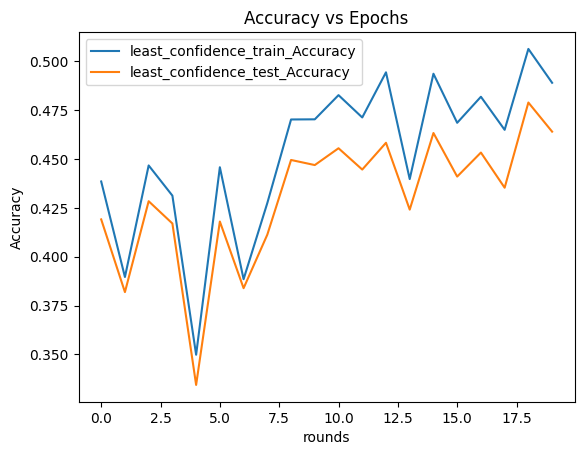

In [7]:
import matplotlib.pyplot as plt

least_confidence_train = [0.4385, 0.389625, 0.4467, 0.43125, 0.34985, 0.44577500000000003, 
             0.3885, 0.427475, 0.470225, 0.4703, 0.482675, 0.47125, 
             0.49435, 0.43972500000000003, 0.49362500000000004, 0.468525, 
             0.48185, 0.46492500000000003, 0.506325, 0.489]
least_confidence_test =[0.4191, 0.3819, 0.4284, 0.417, 0.3344, 0.418, 0.3839, 0.4113, 
            0.4495, 0.4469, 0.4555, 0.4446, 0.4583, 0.4241, 0.4633, 0.441, 
            0.4533, 0.4353, 0.4789, 0.464]

plt.plot(least_confidence_train, label='least_confidence_train_Accuracy')
plt.plot(least_confidence_test, label='least_confidence_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [1]:
!python demo.py --n_round 20 --n_query 100 --n_init_labeled 2000 --dataset_name CIFAR10 --strategy_name MarginSampling

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 20,
 'seed': 1,
 'strategy_name': 'MarginSampling'}

Files already downloaded and verified
Files already downloaded and verified
number of labeled pool: 2000
number of unlabeled pool: 38000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]
Round 0 testing accuracy: 0.3885
``````````````````````````````````````
Round 0 trainng accuracy: 0.4031
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]
Round 1 testing accuracy: 0.4278
```````````````````````````````````
Round 1 trainng accuracy: 0.44272500000000004
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.00it/s]
Round 2 testing accuracy: 0.3699
```````````````````````````````````
Round 2 trainng accuracy: 0.397125
Round 3
100%|█████████████████████████████████

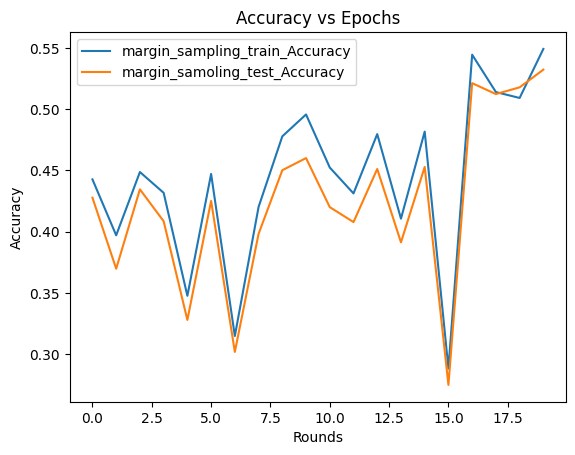

In [6]:
margin_sampling_train = [0.44272500000000004, 0.397125, 0.448725, 0.431775, 0.347775, 0.44715, 0.315, 0.420225, 0.477825, 0.49567500000000003, 0.4524, 0.431275, 0.47965, 0.4107, 0.4817, 0.28845, 0.5444, 0.51395, 0.5091249999999999, 0.5491249999999999]
margin_samoling_test =[0.4278, 0.3699, 0.4346, 0.4086, 0.3281, 0.4252, 0.302, 0.3983, 0.4502, 0.4601, 0.4201, 0.4079, 0.4512, 0.3914, 0.4529, 0.2751, 0.5212, 0.5123, 0.5178, 0.5322145]
plt.plot(margin_sampling_train, label='margin_sampling_train_Accuracy')
plt.plot(margin_samoling_test, label='margin_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [3]:
!python demo.py --n_round 20 --n_query 100 --n_init_labeled 2000 --dataset_name CIFAR10 --strategy_name EntropySampling

{'dataset_name': 'CIFAR10',
 'n_init_labeled': 2000,
 'n_query': 100,
 'n_round': 20,
 'seed': 1,
 'strategy_name': 'EntropySampling'}

Files already downloaded and verified
Files already downloaded and verified
number of labeled pool: 2000
number of unlabeled pool: 38000
number of testing pool: 10000

Round 0
100%|███████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]
Round 0 testing accuracy: 0.3885
``````````````````````````````````````
Round 0 trainng accuracy: 0.4031
Round 1
100%|███████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.01it/s]
Round 1 testing accuracy: 0.4168
```````````````````````````````````
Round 1 trainng accuracy: 0.439775
Round 2
100%|███████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]
Round 2 testing accuracy: 0.4091
```````````````````````````````````
Round 2 trainng accuracy: 0.42
Round 3
100%|███████████████████████████████████████████████

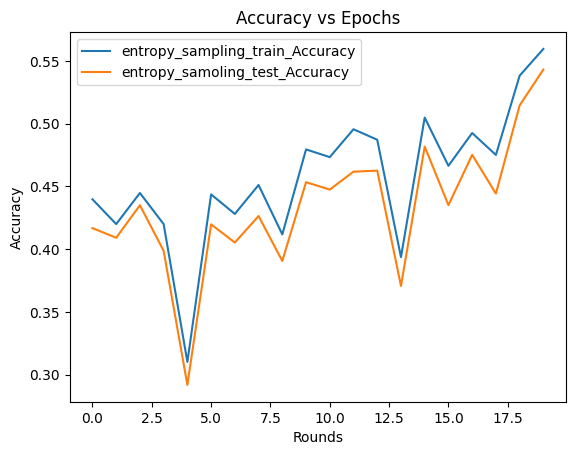

In [5]:
import matplotlib.pyplot as plt
entropy_sampling_train = [0.439775, 0.42, 0.44477500000000003, 0.42, 0.31015,
                0.443675, 0.42810000000000004, 0.45115, 0.411775, 0.47952500000000003,
                0.473375, 0.4956, 0.487225, 0.39365, 0.5049, 0.46645000000000003, 
                0.4926, 0.475125, 0.5382750000000001, 0.559625]
entropy_samoling_test =[0.4168, 0.4091, 0.435, 0.3987, 0.2918,
               0.4198, 0.4053, 0.4264, 0.3906, 0.4534,
               0.4475, 0.4618, 0.4626, 0.3707, 0.4818, 0.4351,
               0.4752, 0.4443, 0.5146, 0.54321]

plt.plot(entropy_sampling_train, label='entropy_sampling_train_Accuracy')
plt.plot(entropy_samoling_test, label='entropy_samoling_test_Accuracy')

plt.title('Accuracy vs Epochs')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()